In [3]:
import pandas as pd 
import numpy as np
select_blackbox = ['decision tree','neural network', 'random forest'][1]

df = pd.read_csv("data/output/result.csv", header=None)
df.columns = ['accuracy', 'blackbox', 'dataset', 'explainer', 'explanation', 'explanation size', 'positive counterexamples', 'query', 'random words checked', 'terminate', 'time', 'time learner', 'time verifier', 'total counterexamples']
df = df[df['blackbox'] == select_blackbox]
print("minimum iterations:", min(df.groupby(['query'])['explanation'].count()), "max iterations:",max(df.groupby(['query'])['explanation'].count()))
df.head()

minimum iterations: 1 max iterations: 1


,accuracy,blackbox,explainer,explanation,explanation size,positive counterexamples,query,random words checked,terminate,time,time learner,time verifier,total counterexamples
0,0.0,neural network,sygus,(or (and hair (not feathers)) (and (not aquat...,6.0,0.5,legs <= 0.2,223.0,0.0,31.012961,27.988794,2.018094,18.0


In [6]:
# take median
group_list = ['explainer','query']
df_med = df.groupby(group_list).median()
df_med.reset_index(inplace=True)
df_med

,explainer,query,accuracy,positive counterexamples,random words checked,terminate,time,time learner,time verifier,total counterexamples
0,decision tree,breathes = 0,1.0,0.428571,191.0,1.0,0.137039,0.076824,0.056539,7.0
1,logistic regression,breathes = 0,1.0,0.437500,699.0,1.0,0.506522,0.304114,0.196521,16.0
2,sygus,breathes = 0,1.0,0.375000,348.0,1.0,4.497904,0.438668,4.056641,8.0


In [7]:
# find representative explanation
query_explanations = {}
for key, item in df.groupby(['explainer','query'], as_index = False):
    item.reset_index(inplace=True, drop=True)
    if(len(item) == 1):
        query_explanations[key] = item['explanation'].item()
    else:
        # nearest explanation to the average accuracy
        explanation = item.iloc[item.index[(item['accuracy']-df_med['accuracy'][(df_med['query'] == key)].item()).abs().argsort()][0]]['explanation']
        query_explanations[key] = explanation

In [8]:
df_output = df_med
df_output = df_output.drop("terminate", axis=1)
df_output['explanation'] = np.nan 
for key in query_explanations:
    df_output['explanation'][(df_output['explainer'] == key[0]) & (df_output['query'] == key[1])] = query_explanations[key]

# reorganise columns
df_output = df_output[[ 'explainer','query', 'explanation', 'accuracy', 'time', 'time learner', 'time verifier', 'random words checked', 'total counterexamples', 'positive counterexamples']]
df_output = df_output.round(2)
df_output.head()

,explainer,query,explanation,accuracy,time,time learner,time verifier,random words checked,total counterexamples,positive counterexamples
0,decision tree,breathes = 0,data/output/dt/2020-08-14 12:03:39.735992.pkl,1.0,0.14,0.08,0.06,191.0,7.0,0.43
1,logistic regression,breathes = 0,[-0.09894426 -0.20193456 -1.349648 0.002403...,1.0,0.51,0.30,0.20,699.0,16.0,0.44
2,sygus,breathes = 0,(and (not eggs) (not breathes)),1.0,4.50,0.44,4.06,348.0,8.0,0.38


### Query

breathes = 0


### Result for decision tree

def tree(hair, feathers, eggs, milk, airborne, aquatic, predator, toothed, backbone, breathes, venomous, fins, legs, tail, domestic, catsize):

    if eggs <= 0.5:
        if breathes <= 0.5:
            return 1
        else:
            return 0
    else:
        return 0



accuracy 1.0





### Query

breathes = 0


### Result for logistic regression

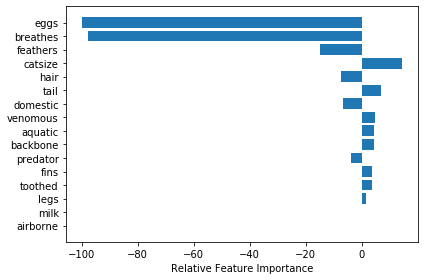



accuracy 1.0





### Query

breathes = 0


### Result for sygus

(and (not eggs) (not breathes))


accuracy 1.0


In [10]:
import matplotlib.pyplot as plt
import pickle
from IPython.display import Markdown, display
from trustable_explanation import helper_functions
import numpy as np


features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
# print results in an explainable manner
for key, item in df_output.groupby(['query','explainer'], as_index = False):
    print("\n\n")
    display(Markdown("### Query"))
    print(key[0])
    display(Markdown("### Result for " + key[1]))
    if(key[1] == "logistic regression"):
        feature_importance = np.fromstring(item['explanation'].item()[1:-1], dtype=np.float, sep=' ')
        feature_importance = 100.0 * (feature_importance / (abs(feature_importance).max()))
        sorted_idx = np.argsort(abs(feature_importance))
        pos = np.arange(sorted_idx.shape[0]) + .5
        featfig = plt.figure()
        featax = featfig.add_subplot(1, 1, 1)
        featax.barh(pos, feature_importance[sorted_idx], align='center')
        featax.set_yticks(pos)
        featax.set_yticklabels(np.array(features)[sorted_idx])
        featax.set_xlabel('Relative Feature Importance')
        plt.tight_layout()   
        plt.show()
    elif(key[1] == "decision tree"):
        dt = None
        with open(item['explanation'].item(), 'rb') as fid:
            dt = pickle.load(fid)
        print(helper_functions.tree_to_code(dt,features))
    else:
        print(item['explanation'].item())
    print("\n\naccuracy",item['accuracy'].item())


In [70]:
# to remote 
# df_output.to_csv("data/output/summary.csv", index = False)
df_output.to_csv("/home/bishwamittra/Dropbox/trustable_explanations/result.csv", index = False)